In [57]:
import pandas as pd

In [58]:
df_matches = pd.read_csv('../data/preprocessed/preprocessed_1.csv')

In [59]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

def train_and_evaluate(train_df, val_df):
    X_train = train_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_train = train_df["result_match"]

    X_val = val_df.drop(columns=["result_match", "season", "date", "home_team", "away_team"])
    y_val = val_df["result_match"]

    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    accuracy = f1_score(y_val, y_pred)
    return accuracy

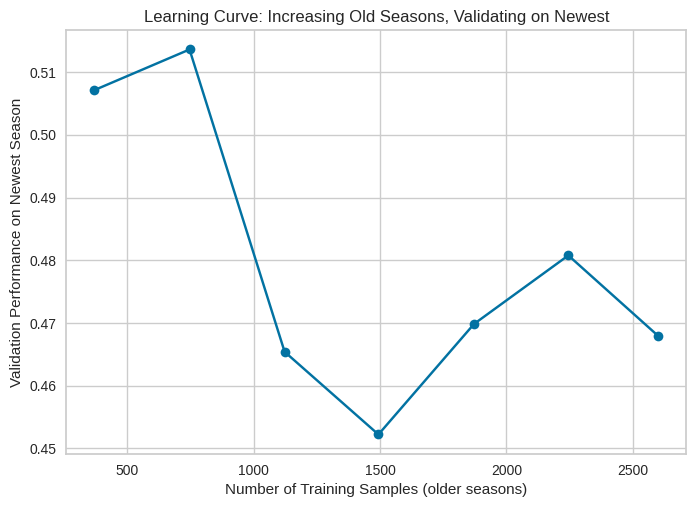

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

sorted_seasons = sorted(df_matches["season"].unique())
newest_season = sorted_seasons[-1]
older_seasons = sorted_seasons[:-1]

train_sizes = []
performances = []

for i in range(1, len(older_seasons) + 1):
    train_seasons = sorted(older_seasons[-i:], reverse=True)

    train_df = df_matches[df_matches["season"].isin(train_seasons)]
    val_df   = df_matches[df_matches["season"] == newest_season]

    performance_metric = train_and_evaluate(train_df, val_df)

    train_sizes.append(len(train_df))
    performances.append(performance_metric)

learning_curve_df = pd.DataFrame({
    'train_size': train_sizes,
    'performance': performances
})

plt.plot(learning_curve_df['train_size'], learning_curve_df['performance'], marker='o')
plt.xlabel('Number of Training Samples (older seasons)')
plt.ylabel('Validation Performance on Newest Season')
plt.title('Learning Curve: Increasing Old Seasons, Validating on Newest')
plt.show()

In [61]:
df_matches = df_matches.sort_values(by=["season", "stage", "date"])

seasons = sorted(df_matches.season.unique()[-2:], reverse=True)

df_ = df_matches[df_matches["season"].isin(seasons)]

X = df_.drop(columns=["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"])
y = df_["result_match"]

In [64]:
X.shape

(745, 34)